In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[11] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [4]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [5]:
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/(2*N**2)
    return ES


In [107]:
def WIS_average(X,Y):
    S = X[0]
    I = X[1]
    R = X[2]
    
    y_S = Y[0]
    y_I = Y[1]
    y_R = Y[2]
    
    WIS_S = WIS(S,y_S)
    WIS_I = WIS(I,y_I)
    WIS_R = WIS(R,y_R)
    
    WIS_mean = np.mean([WIS_S/(np.sum(y_S)), WIS_I/(np.sum(y_I)), WIS_R/(np.sum(y_R))])
    
    return WIS_mean

# proper vs strictly proper for SIR curve

In [6]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



In [11]:
# only keep first 60 time steps
n=0
Sfilt = {}
Ifilt = {}
Rfilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Sfilt[n] = Sall[i][0:60]
        Ifilt[n] = Iall[i][0:60]
        Rfilt[n] = Rall[i][0:60]
        
        n+=1

In [13]:
# save infection trajectories in dataframe
SIRdf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    trajS = Sfilt[it]
    trajI = Ifilt[it]
    trajR = Rfilt[it]
    
    for t in time:
        valS = trajS[t-1]
        valI = trajI[t-1]
        valR = trajR[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'S':valS, 'I':valI,'R':valR}, index=[0])
        
        SIRdf = pd.concat([SIRdf, newrow])
    

Text(0, 0.5, 'Number of infectious individual')

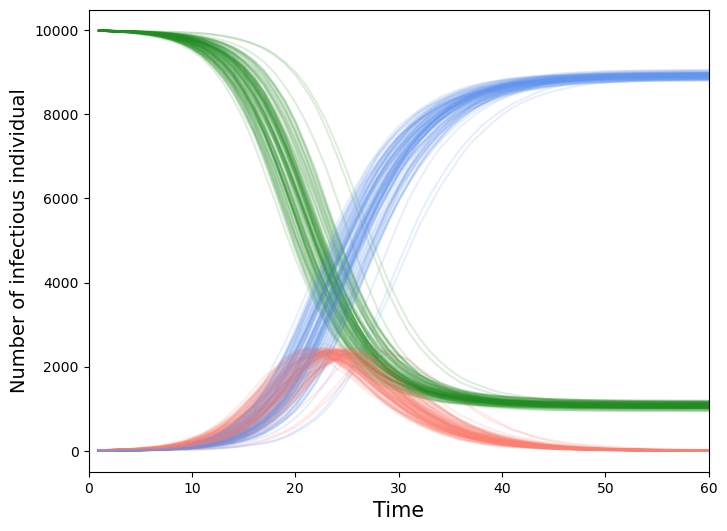

In [16]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
        
for i in SIRdf.trajectory_id.unique():
    if i<500:
        d = SIRdf[SIRdf.trajectory_id==i]
        plt.plot(d.time, d.S, color='forestgreen', alpha=.15)
        plt.plot(d.time, d.I, color='salmon', alpha=.15)
        plt.plot(d.time, d.R, color='cornflowerblue', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

In [48]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Sfilt = {}
    Ifilt = {}
    Rfilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Sfilt[n] = Sall[i][0:60]
            Ifilt[n] = Iall[i][0:60]
            Rfilt[n] = Rall[i][0:60]

            n+=1

    SIRdf = pd.DataFrame()

    time = list(range(1, 61))

    for it in range(1, 21):
        trajS = Sfilt[it]
        trajI = Ifilt[it]
        trajR = Rfilt[it]

        for t in time:
            valS = trajS[t-1]
            valI = trajI[t-1]
            valR = trajR[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'S':valS, 'I':valI,'R':valR}, index=[0])

            SIRdf = pd.concat([SIRdf, newrow])
    
    
    miscorrdf = SIRdf.rename(columns={'S':'R','R':'S'}) # swap S and R columns
    

    SIRdf['Model'] = 'SIR'
    miscorrdf['Model'] = 'miscorrelated SIR'

    dftot = pd.concat([SIRdf, miscorrdf])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [108]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 20

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y_S=np.array([])
    while y_S.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y_S = np.array(Sall[0][0:60]).astype(float) 
        y_I = np.array(Iall[0][0:60]).astype(float) 
        y_R = np.array(Rall[0][0:60]).astype(float) 
        
        Y = [y_S, y_I, y_R]
        y = np.array([y_S, y_I, y_R])
        
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
    
    S_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].S) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    I_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    R_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].R) for i in SIRdf['trajectory_id'].unique()]).astype(float) 

    SIRlist =[S_X, I_X, R_X]

    SIR_X = []
    for i in range(len(S_X)):
        S = S_X[i]
        I = I_X[i]
        R = R_X[i]

        SIR_X.append(np.array([S,I,R]))

    SIR_X = np.array(SIR_X)

    ####### miscorrelated SIR ########
    
    shiftdf = dftot[dftot.Model=='miscorrelated SIR'].sort_values(by='time')
    
    S_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].S) for i in shiftdf['trajectory_id'].unique()]).astype(float) 
    I_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 
    R_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].R) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    miscorrlist = [S_X, I_X, R_X]

    miscorr_X = []
    for i in range(len(S_X)):
        S = S_X[i]
        I = I_X[i]
        R = R_X[i]

        miscorr_X.append(np.array([S,I,R]))

    miscorr_X = np.array(miscorr_X)

    
    # calculate scores
    ES_SIR.append(energyscore_multipletargets(SIR_X , y))
    ES_shift.append(energyscore_multipletargets(miscorr_X, y))
    
    
    WIS_SIR.append(WIS_average(SIRlist, Y))
    WIS_shift.append(WIS_average(miscorrlist, Y))
    
    

In [109]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'miscorrelated SIR', 'value':ES_shift,
                                     'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'miscorrelated SIR', 'value':WIS_shift,
                                       'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

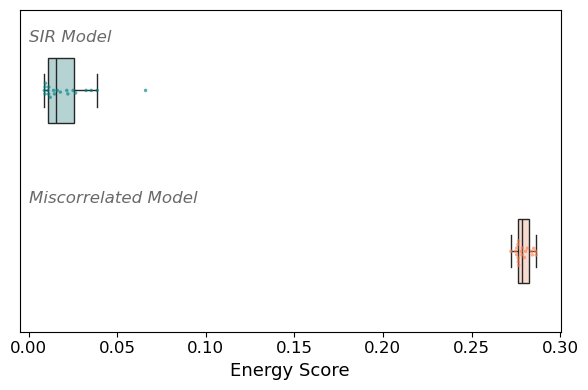

In [110]:
fig,ax = plt.subplots(figsize=(6,4))
palette = ['teal', 'coral']

df = ESdf.copy()


g=sns.boxplot(x='value', y='Model', data=df,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=df,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Miscorrelated Model']:
    plt.text(0,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xlim([0,3500])    
    
plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots_1115.pdf')
plt.show()

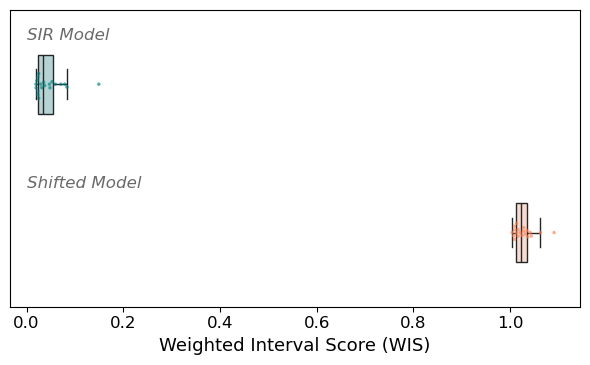

In [111]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = WISdf.copy()

g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

#plt.xlim([0,17500])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(0,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots_1115.pdf')
plt.show()

In [112]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='miscorrelated SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='miscorrelated SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-32.152777777777786, 0.5, '')

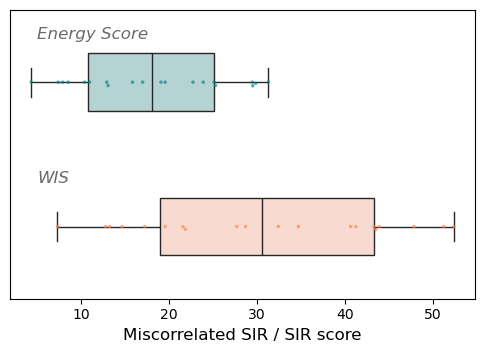

In [113]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score', 'WIS']:
    plt.text(5,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Miscorrelated SIR / SIR score',fontsize=12)
plt.ylabel('')